In [1]:
import glob
import numpy as np
from utils.read_ADC_bin_TDA2_separateFiles import read_adc_bin_tda2_separate_files
from utils.rangeProcCascade import rangeProc
from utils.DopplerProcCascade import dopplerProc
from utils import cfar_caso
import seaborn as sns

In [11]:
num_sample_per_chirp=256
num_chirp_per_loop=12
num_loops=64
num_rx_per_device=4
num_devices=1
chunk_size = num_sample_per_chirp*num_chirp_per_loop*num_loops*num_rx_per_device*num_devices*4
RxForMimoProcess = [12,13,14,15,0,1,2,3,8,9,10,11,4,5,6,7]

In [3]:
def bin2np_frame(bin_frame):  #
    neg = np.bitwise_and(bin_frame, 1 << 15) != 0
    bin_frame[neg] = bin_frame[neg]-(2**16)
    bin_frame = bin_frame[0::2] + 1j * bin_frame[1::2]
    bin_frame = np.reshape(bin_frame, (num_rx_per_device, num_sample_per_chirp, num_chirp_per_loop, num_loops), order='F')
    bin_frame = np.transpose(bin_frame,axes=(1,3,0,2))
    return bin_frame

In [4]:
filepath = r"C:\ti\mmwave_studio_02_01_01_00\mmWaveStudio\PostProc\cascade_cpu_head_1\\*.bin"

In [5]:
def get_valid_num_frames(adc_idx_file_name):
    header_info_size = 6
    with open(adc_idx_file_name, 'rb') as idx_file:
        header_info = np.fromfile(idx_file, dtype=np.uint32, count=header_info_size)
        num_idx = header_info[3]  
    
    header_info_size = 3
    with open(adc_idx_file_name, 'rb') as idx_file:
        header_info = np.fromfile(idx_file, dtype=np.uint64, count=header_info_size)
        data_file_size = header_info[2]  
    
    return num_idx, data_file_size


In [6]:
data_files = glob.glob(filepath)
num_frames = 0 
data_file_size = 0
for file in data_files:
    if 'master_0000_idx' in file:
        num_frames, data_file_size = get_valid_num_frames(file)
        print(f"Number of Frames: {num_frames}")
        print(f"Data File Size: {data_file_size}")

Number of Frames: 99
Data File Size: 311427072


In [31]:
angleFFTs_sum_frames = np.zeros((num_frames, 256, 256))
file_paths = {}
dtype=np.uint16
for file in data_files:
    if 'data' in file:
        if 'master' in file:
            file_paths['master'] = file
        elif 'slave1' in file:
            file_paths['slave1'] = file
        elif 'slave2' in file:
            file_paths['slave2'] = file
        elif 'slave3' in file:
            file_paths['slave3'] = file
with open(file_paths['master'], 'rb') as f_master, \
     open(file_paths['slave1'], 'rb') as f_slave1, \
     open(file_paths['slave2'], 'rb') as f_slave2, \
     open(file_paths['slave3'], 'rb') as f_slave3:
    for frame_no in range(30):
        masterArr = bin2np_frame(np.frombuffer(f_master.read(chunk_size), dtype=np.int16).copy())
        slave1_arr = bin2np_frame(np.frombuffer(f_slave1.read(chunk_size), dtype=np.int16).copy())
        slave2_arr = bin2np_frame(np.frombuffer(f_slave2.read(chunk_size), dtype=np.int16).copy())
        slave3_arr = bin2np_frame(np.frombuffer(f_slave3.read(chunk_size), dtype=np.int16).copy())
        radar_cube=np.zeros(shape=(256,64,16,12), dtype=np.complex_)
        radar_cube[:,:,0:4,:] = masterArr
        radar_cube[:,:,4:8,:] = slave1_arr
        radar_cube[:,:,8:12,:] = slave2_arr
        radar_cube[:,:,12:,:] = slave3_arr
        radar_cube = radar_cube[:,:,RxForMimoProcess,:]
        print(radar_cube.shape)
        print(radar_cube[0,0,1,0:10])
        rangeFFTOut = np.zeros(shape=radar_cube.shape, dtype=np.complex_)
        DopplerFFTOut = np.zeros(shape=radar_cube.shape, dtype=np.complex_)
        for i_tx in range(radar_cube.shape[3]):
            rangeFFTOut[:,:,:,i_tx] = rangeProc(radar_cube[:,:,:,i_tx])
            DopplerFFTOut[:,:,:,i_tx] = dopplerProc(rangeFFTOut[:,:,:,i_tx])
        DopplerFFTOut =  np.reshape(
            DopplerFFTOut, 
            (DopplerFFTOut.shape[0], DopplerFFTOut.shape[1], DopplerFFTOut.shape[2] * DopplerFFTOut.shape[3])
        )
        sig_integrate = 10 * np.log10(np.sum(np.abs(DopplerFFTOut)**2, axis=2) + 1)
        if frame_no == 1:
            break

(256, 64, 16, 12)
[  485.-3654.j  3611.+1549.j -1767.+2995.j -5219.-2331.j  2764.+1272.j
 -2488.-2090.j  6678.-2035.j -1934. +389.j -5707.+3370.j -1172.+1160.j]
(256, 64, 16, 12)
[-2632.-2037.j  7016.-2004.j -1533. +386.j -5091.+3272.j  -504. +770.j
  2479.-1394.j -1026. -551.j   117.-3409.j  2791.+1715.j -1453.+2760.j]


<AxesSubplot:>

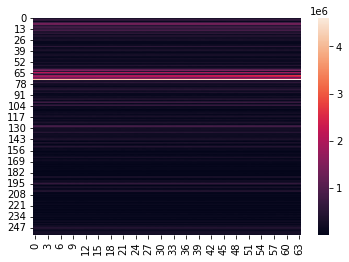

In [32]:
sns.heatmap(np.abs(np.sum(rangeFFTOut,axis=(2,3))))

In [33]:
np.abs(np.sum(rangeFFTOut,axis=(2,3)))[:10,0]

array([ 143068.39883567,  348827.32739185,  661555.94312731,
        511082.52129343,  119227.79511724,  740918.55646594,
       1357350.15702486, 1231280.15785517, 1261175.76853025,
        470180.70001899])